# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Changing-Color-space" data-toc-modified-id="Changing-Color-space-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Changing Color-space</a></div><div class="lev2 toc-item"><a href="#Histogram-Equalization" data-toc-modified-id="Histogram-Equalization-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Histogram Equalization</a></div><div class="lev1 toc-item"><a href="#Model" data-toc-modified-id="Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model</a></div>

### Changing Color-space

> For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].

> `mpimg.imread()` will read in an **RGB** image: convert to grayscale using `cv2.COLOR_RGB2GRAY`

> `cv2.imread()` or the **glob API** will read in a **BGR** image: convert to grayscale using `cv2.COLOR_BGR2GRAY`.

> dtype=uint8  pixel range is [0,255]

In [11]:
# ref: https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html
def HSV_space(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def image_Normalization(img_batches):
    return ((np.float32(img_batches)-128.0) / 128.0)

def grayscale(img_batches):
    # cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return np.expand_dims(0.21 * img_batches[:,:,:,0] + 0.72 * img_batches[:,:,:,1] + 0.07 * img_batches[:,:,:,2], axis=-1)

def grayscale_cv2(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [12]:
## Label Binarizer for classes
def OneHotEncoding(y_class):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_class)
    return lb

def batch_iteration(train_x, train_y, batch_size, start=0):
    n_sample = train_x.shape[0]
    n = start
    for i in range(0, n_sample, batch_size):
        yield (n, train_x[i:i + batch_size], train_y[i:i + batch_size])
        n += 1

In [13]:
def HistEqualizer(grayscale_img):
    return cv2.equalizeHist(grayscale_img)

def ClaheEqualizer(grayscale_img, tileSize = 8, clipLim = 2.0):
    clahe = cv2.createCLAHE(clipLimit=clipLim, tileGridSize=(tileSize,tileSize))
    return clahe.apply(grayscale_img)

### Histogram Equalization

* Enhancing the contrast in an image, bringing out details which were hard to see before.
* ref: https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

* CLAHE (Contrast Limited Adaptive Histogram Equalization)

With **adaptive histogram equalization**, image is divided into small tiles. Then each of these titles are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If *noise* is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit, those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove *artifacts in tile borders*, bilinear interpolation is applied.

In [14]:
def plot_of_equalizer(img):
    # equalizer
    equ_img = cv2.equalizeHist(img)
    # clahe
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl_img = clahe.apply(img)

    # stacking images side-by-side
    res = np.hstack((img, equ_img, cl_img))
    plt.imshow(res);
    plt.axis('off');
    return (img, equ_img, cl_img)

def plot_of_grayscaleHistogram(imgs):
    origin_img, equ_img, cl_img = imgs
    # Three subplots sharing both x/y axes
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
    ax1.hist(origin_img.flatten(),256,[0,256], color = 'r')
    ax1.set_title('grayscale histogram of original img, histo equalizer, Clahe')
    ax2.hist(equ_img.flatten(),256,[0,256], color = 'r')
    ax3.hist(cl_img.flatten(),256,[0,256], color = 'r')
    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.show()

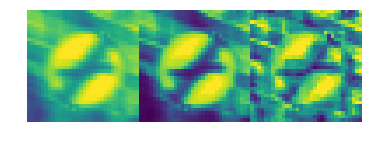

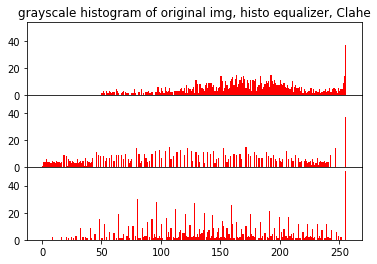

In [15]:
img = X_train[50]
grayscale_img = grayscale_cv2(img)
equalizer_images = plot_of_equalizer(grayscale_img)
plot_of_grayscaleHistogram(equalizer_images)

## Model

* Example
  - Input width = 13
  - Filter width = 6
  - Stride = 5

* "VALID" = without padding:

In [633]:
"""
inputs:     1  2  3  4  5  6  7  8  9  10  11  (12  13)
            |______________|                 dropped
                           |________________|
""";

* "SAME" = with zero padding:

In [634]:
"""
         pad|                                           |pad
  inputs: 0-|-1--2--3--4--5--6--7--8--9--10--11--12--13-|-0--0
          |_______________|
                          |_______________|
                                          |__________________|
""";

> **VALID** only ever drops the right-most columns (or bottom-most rows).

> **SAME** tries to pad evenly left and right, but if the amount of columns to be added is odd, it will add the extra column to the right, as is the case in this example (the same logic applies vertically: there may be an extra row of zeros at the bottom).